In [5]:
import pandas as pd
import numpy as np
import re #Regex lib
from forex_python.converter import CurrencyRates #currencies lib
from datetime import datetime
import matplotlib

### Read in the dataframes and create a dict {(year, dataframe)}


In [6]:
# Create a list of filenames for the datasets
years = [2017, 2018, 2019, 2020, 2021]
file_names = ['datasets/{}.csv'.format(year) for year in years]

# Read in the dataframes and create a dict {(year, dataframe)}
data_frames = [pd.read_csv(file_name, encoding = "ISO-8859-1") for file_name in file_names]
data_frames_dict = {}

for year, df in zip (years,data_frames):
    data_frames_dict[year] = df

/var/folders/h2/9wb_tlwj1bd2smbvq_25k5z4097jdb/T/ipykernel_15570/3359778430.py:6: DtypeWarning: Columns (8,12,13,14,15,16,50,51,52,53,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128) have mixed types.Specify dtype option on import or set low_memory=False.
  data_frames = [pd.read_csv(file_name, encoding = "ISO-8859-1") for file_name in file_names]


### obtain developer types 


/var/folders/h2/9wb_tlwj1bd2smbvq_25k5z4097jdb/T/ipykernel_15570/4414435.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DevTypes_count_per_user'] = df.DevType.apply(lambda s:len(get_unique_devetypes(s)))
/usr/local/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


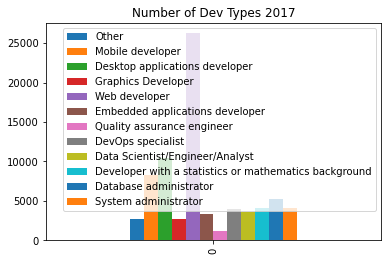

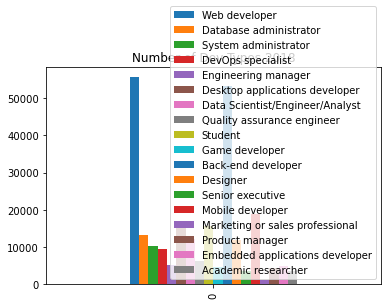

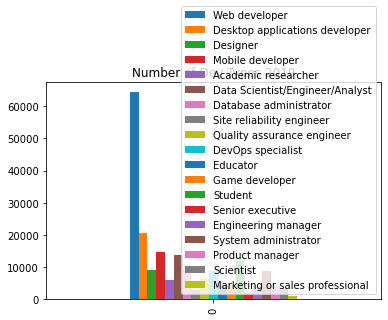

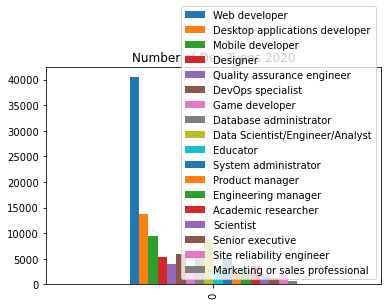

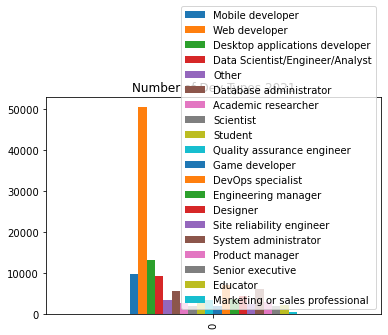

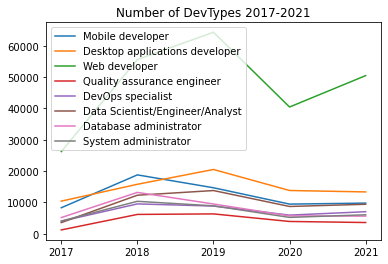

In [7]:
df_2017 = data_frames_dict[2017]

# Change column name  DeveloperType in 2017  to DevType
df_2017.columns = ['DevType' if x=='DeveloperType' else x for x in df_2017.columns]

data_frames_dict[2017] = df_2017

# This is a dict that maps similar kinds of devs to one common name
devTypes_clean_dict= { 'C-suite executive (CEO, CTO, etc.)': 'Senior executive',
 'Data or business analyst': 'Data Scientist/Engineer/Analyst',
 'Data scientist' : 'Data Scientist/Engineer/Analyst',
 'Data scientist or machine learning specialist': 'Data Scientist/Engineer/Analyst',
 'Desktop or enterprise applications developer':  'Desktop applications developer',
 'Developer, QA or test':  'Quality assurance engineer',
 'Developer, back-end': "Web developer",
 'Developer, desktop or enterprise applications':'Desktop applications developer',
 'Developer, embedded applications or devices' :'Desktop applications developer',
 'Developer, front-end': "Web developer",
 'Developer, full-stack' : 'Web developer',
 'Developer, game or graphics': 'Game developer',
 'Developer, mobile':  'Mobile developer',
 'Graphic designer': "Graphics Developer", 
 'Graphics programming': "Graphics Developer",             
 'Educator or academic researcher': 'Academic researcher',
 'Embedded applications or devices developer': 'Embedded applications developer',
 'Embedded applications/devices developer': 'Embedded applications developer',
 'Engineer, data': 'Data Scientist/Engineer/Analyst',
 'Front-end developer':  "Web developer",
 'Full-stack developer': "Web developer",
 'Game or graphics developer' : 'Game developer',
 'Machine learning specialist' : 'Data Scientist/Engineer/Analyst',
 'Other (please specify):': 'Other',
 'QA or test developer' : 'Quality assurance engineer',
 'Senior Executive (C-Suite, VP, etc.)': 'Senior executive',
 'Senior executive/VP': 'Senior executive',
 'Systems administrator': 'System administrator',
 'Engineer, site reliability': 'Site reliability engineer',
 }
#helper function to map a string into a list of unique dev types
def get_unique_devetypes(devtypesEntry):
    types = map(lambda s: s.strip(), devtypesEntry.split(';'))
    return list(set(map(lambda s: devTypes_clean_dict[s] if s in devTypes_clean_dict else s,types )))

#select only rows with devtype entry 
for year, df in data_frames_dict.items(): 
    if 'DevType' in df:
        data_frames_dict[year] = df[df.DevType.apply(lambda s: not pd.isna(s))]
        

# This for loop was used to identify different kinds of devtypes that can map to a similar dev type
# it was used in the construction of the devTypes_clean_dict above 
devTypes = set()
for year, df in data_frames_dict.items(): 
    if 'DevType' in df:
        for devType in df.DevType:
                #split into devtypes and remove end and start spaces from each type
                devTypes.update(get_unique_devetypes(devType))

 
# create a column in each year dataframe that is a list of unique dev types a user submitted as their devType            
for year, df in data_frames_dict.items(): 
    if 'DevType' in df:      
        df['DevTypes_count_per_user'] = df.DevType.apply(lambda s:len(get_unique_devetypes(s)))
        df.DevType = df.DevType.apply(lambda s:get_unique_devetypes(s))
        data_frames_dict[year] = df
  
# For each year, count the number of each devtype reported 
dev_type_count_per_year = {}   
for year, df in data_frames_dict.items(): 
    if 'DevType' in df:    
        dev_type_count = {}   
        for devType_list in df.DevType:
            for t in devType_list:
                if t in dev_type_count:
                    dev_type_count[t] = dev_type_count[t] + 1
                else:
                    dev_type_count[t] = 1
        dev_counts_df = pd.DataFrame(dev_type_count, index=[0])
        dev_counts_df.plot(kind='bar', title = 'Number of Dev Types {}'.format(year)) 
        
        dev_type_count_per_year[year] = dev_counts_df.T

        
# Compute a summary_df for the number of each devtypes submitted accross the years       
summary_df = None
i = 0
for year, df in dev_type_count_per_year.items():
    # use the index column as the DevType type column
    df['DevType'] = df.index
    
    # add column names 
    df.columns = [year, 'DevType']
    
    #Swap the columns
    df=df.reindex(columns=['DevType', year ])
    
    # merge the resulting dataframes into a single df columns = years, rows = number of devs of each type
    if i > 0:
        summary_df = pd.DataFrame.merge(summary_df,df,on='DevType')
        i+=1 
    else:
        summary_df =  df
        i+=1

        
summary_df = summary_df.T

# Pick all the countries -> first row of the transposed matrix
column_names = summary_df.iloc[0]
column_names = list(column_names) 

# drop the first row containing countries' names, instead make the countries the column names 
summary_df = summary_df.drop('DevType')
summary_df.columns = column_names
summary_df.plot(xticks = [2017, 2018, 2019, 2020, 2021], title='Number of DevTypes 2017-2021')

summary_df.to_json(path_or_buf = 'processed_data/dev_types/global_number_of_devs_per_year.json', index=True, indent=4)

In [8]:
summary_df

,Mobile developer,Desktop applications developer,Web developer,Quality assurance engineer,DevOps specialist,Data Scientist/Engineer/Analyst,Database administrator,System administrator
2017,8326,10435,26235,1252,4015,3595,5192,4086
2018,18804,15807,55591,6194,9549,12319,13216,10375
2019,14698,20528,64296,6359,8862,13808,9520,8929
2020,9482,13826,40453,3947,5969,8726,5722,5242
2021,9800,13369,50465,3611,7058,9435,5655,6079
